# Perceptron - Custos e Algoritmos

Refatorando os códigos obtidos em sala de aula.

##### Criando datasets para treinamento e testes de conceito

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def CriaDataSetClassificacao(n=20, slop=[2,1], intercept=-0.4): 
    '''
    Cria um dataser para classificação binária com n amostras.
    '''

    X = np.random.uniform(size=(n,2))
    AUX = np.multiply(X,slop)-[0, intercept]
    y = (AUX[:,0] > X[:,1])*2-1
    
    return X, y

def CriaDataSetRegressao(n=20, slop=0.5, intercept=0.2): 
    '''
    Cria um dataser para regressão n amostras com uma dimensão.
    '''

    X = np.random.uniform(size=(n,1)) #n,1 apenas uma dimensão
    AUX = np.random.rand(n,1)-0.5
    
    y = X*slop + intercept + AUX*0.1
    y = y.flatten()
    
    return X, y

def CriaDataSetRegularizacao(n=20, slop=[2,1], intercept=-0.4, dummy_features=3): 
    '''
    Dataset para ilustrar regularização no treinamento.
    Criaremos uma base que possui algum ruído proposital para avaliar o comportamento do treinamento com ele.
    '''
    
    X = np.random.uniform(size=(n,dummy_features))
    AUX = np.multiply(X[:,:2],slop)-[0, intercept] # equivalente @, multiplicação de matrizes
    y = np.array(AUX[:,0] > AUX[:,1], dtype=int)*2-1
    
    return X, y

def plotDatasetRegressao(X, y):
    '''
    Função para plotar o dataset para a regressão, pois difere devido a apenas
    uma dimensão do X.
    '''
    
    plt.plot(X[:,0], y, "o", alpha=0.3)
    


##### Funções para visualização gráfica de resultados com plot dos dados.

In [2]:
import matplotlib.pyplot as plt

def plotDataSet(X,y):
    '''
    Exibe gráfico com os dados da base gerada dividindo em cores distintas os grupos diferentes.
    '''
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    '''
    Plota a linha que divide a base de dados sobre o gráfico.
    '''
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

def PlotCusto(custos):
    '''
    Plota o gráfico de iterações x custo do aprendizado para avaliação do quão rápido a rede aprendeu a classificação.
    '''
    if (len(custos) == 0):
        print('ERRO: Modelo ainda não treinado para avaliar o custo!')
        return
    
    x = [i for i in range(1,len(custos) + 1)]

    plt.xlabel('Nº Iterações')
    plt.ylabel('Custo')
    plt.plot(x, custos, "-")
    plt.show()

### Funções de custo

Criaremos uma classe genérica para definição do custo. Cada abordagem de custo herdará desta classe e definirá os métodos de "custo" e gradiente", especializando conforme a proposta de cada algoritmo.

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod, abstractstaticmethod
import random

class Custo(ABC):
    '''
    Classe de custo
    '''
    @abstractstaticmethod
    def custo(self, y, ypred):
        pass

    @abstractstaticmethod
    def gradiente(self, y, ypred):
        pass

#### Função de custo - WidrowHoff

In [4]:
class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((y - ypred)**2)
    
    @staticmethod
    def gradiente(y, ypred):
        return y - ypred

In [5]:
def sign(a):
    return (a >= 0)*2-1

def accuracy(yactual, ypred):
    return sum(yactual==ypred)/len(yactual)

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass

class PseudoInversa(TrainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
    
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        else:
            '''
            a formula matematica: (X'X + I*r)^(-1) X'y
            '''
            f1 = (X.T @ X)
            I = np.identity(f1.shape[0])
            f2 = I*self.regularization
            print('f1',f1)
            print('f2',f2)
            fator = f1 + f2
            
            w = np.linalg.pinv(fator) @ X.T * y
            return w
             
class DescidaGradiente(TrainingAlgorithm):
    def __init__(self,max_iter=100,learning_rate=0.02, regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        
        #evitar overfiting. Funciona como uma "taxa de esquecimento" no aprendizado
        #quanto maior a regularização, mais esquecimento do w anterior eu tenho na nova iteração
        self.regularization = regularization
        self.cost = cost
        self.custos = []

    def getW(self,X,y):
        w = np.random.uniform(-1,1,size=X.shape[1])
        
        for j in range(self.max_iter):
            ypred = X @ w
                        
            c = self.cost.custo(y, ypred) 
            #custos
            self.custos.append(c)

            if c == 0:
                break            

            #aplicando a regularização..
            w *= 1 - self.learning_rate * self.regularization
            w += (X.T @ self.cost.gradiente(y, ypred)) * self.learning_rate
            
        return w
     
class Perceptron(BaseEstimator, ClassifierMixin):
    '''
    Deinfinição da rede Perceptron. O algoritmo de aprednizagem pode ser definido sendo passado por parâmetro.
    Assim, conforme os dois exemplos anteriores, duas abordagens possíveis são a PseudoInversa e a DescidaGradiente.
    '''
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
    
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        
        return Xb
        
    def predict(self, X, y=None):
        '''
        Função para predição com dados de testes.
        '''
        Xb = self.includeBias(X)
        a = Xb @ self.w
        ypred = self.activation(a)
        
        return ypred
    
    
    def fit(self, X, y):
        '''
        Treinamento do perceptron.
        '''

        Xb = Perceptron.includeBias(X)
        self.w = self.training_algorithm.getW(Xb, y)


### Perceptron - teste com algoritmo PseudoInversa

1.0


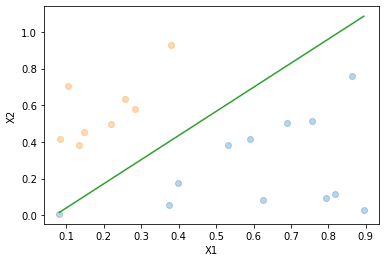

In [6]:
X, y = CriaDataSetClassificacao()

percep = Perceptron(training_algorithm=PseudoInversa())
percep.fit(X,y)
ypred = percep.predict(X)

#comparando quantos são iguais e divide pelo tamanho: resultado é a acuracia
print(sum(ypred==y)/len(y))

plotDataSet(X, y)
plotHiperplano(X,y,percep.w[1:], percep.w[0])
plt.show()

### Custo > WildrowHoff

1.0


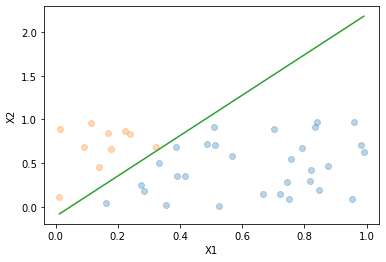

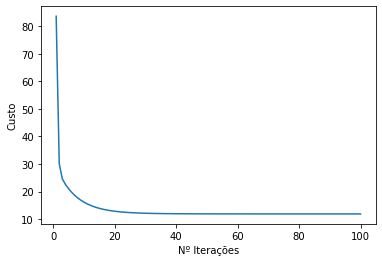

In [7]:
class WidrowHoff(Custo):
    '''
    Esta função de custo sofre com a distância de pontos distantes do hiperplano.
    Quem está distante influencia o coeficiente final.
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum((y - ypred)**2)
    
    @staticmethod
    def gradiente(y, ypred):
        return y - ypred

X, y = CriaDataSetClassificacao(n=40)

percep = Perceptron(DescidaGradiente(cost=WidrowHoff()))
percep.fit(X,y)
ypred = percep.predict(X)
print(sum(ypred==y)/len(y))

plotDataSet(X, y)
plotHiperplano(X,y,percep.w[1:], percep.w[0])
plt.show()

PlotCusto(percep.training_algorithm.custos)

#### SmoothedSurrogate


0.973


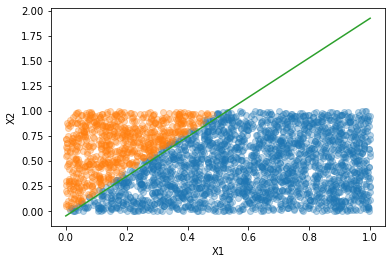

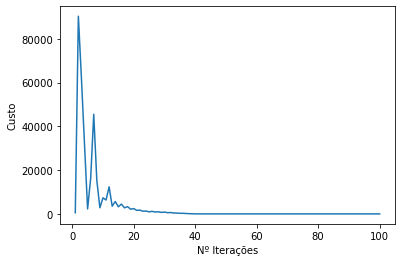

In [8]:
class SmoothedSurrogate(Custo):
    '''
    Função de custo cujo gradiente utiliza o mesmo método do PLA Perseptron inicial (Aula1), mas
    a função de custo é calculada de forma diferente.

    custo = - y * ypred
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), -y*ypred))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - sign(ypred)
    

X, y = CriaDataSetClassificacao(n=3000)

percep = Perceptron(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(X,y)
ypred = percep.predict(X)
print(sum(ypred==y)/len(y))

plotDataSet(X, y)
plotHiperplano(X,y,percep.w[1:], percep.w[0])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

#### LoglikeHood

0.9986666666666667


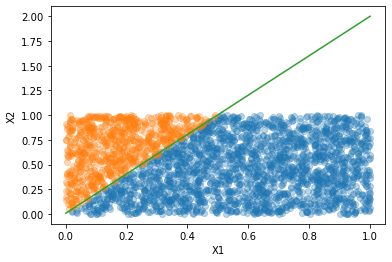

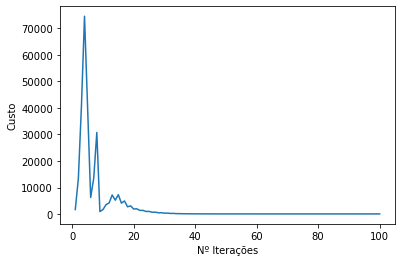

In [9]:
from scipy.special import expit

class LogLikehood(Custo):
    '''
    
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - (expit(ypred)*2 -1 )

X, y = CriaDataSetClassificacao(n=3000)

percep = Perceptron(DescidaGradiente(cost=LogLikehood()))
percep.fit(X,y)
ypred = percep.predict(X)
print(sum(ypred==y)/len(y))

plotDataSet(X, y)
plotHiperplano(X,y,percep.w[1:], percep.w[0])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

#### HingeLoss

0.97


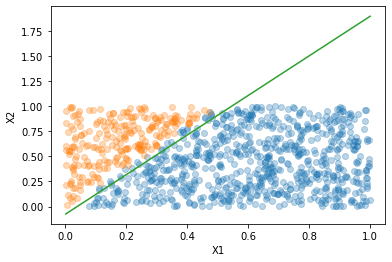

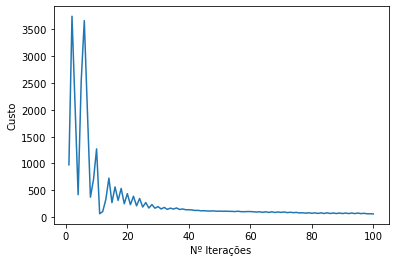

In [10]:
class HingeLoss(Custo):
    '''
    Função de custo tende a considerar quem está mais próximo do hiperplano.
    custo -> 1 - y * ypred
    gradiente -> considera os erros negativos com maior rigor que os positivos, de forma a penalizar
    o algoritmo quando erra muito negativamente (errosmarginais) 
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - (y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        #filtro para encontrar os erros marginais
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        
        #zerando todos os erros que não são marginais
        #invertendo os indices, 
        ymarginais[~errosmarginais] = 0 

        return ymarginais

X, y = CriaDataSetClassificacao(n=1000)

percep = Perceptron(DescidaGradiente(cost=HingeLoss(), learning_rate=0.02))
percep.fit(X,y)
ypred = percep.predict(X)
print(sum(ypred==y)/len(y))

plotDataSet(X, y)
plotHiperplano(X,y,percep.w[1:], percep.w[0])
plt.show() 

PlotCusto(percep.training_algorithm.custos)